<img src="../code/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Tutorial on behavior states</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 24th, 2023</h3> 
<h4 align="center">Day 4 team</h4> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> In Workshop 1, we manually identified behavioral states by assessing the mouse's performance. We also learnt of complementary behaviors linked with these states. However, these behavioral variables were not integrated into our state definitions. Instead, our determination of state boundaries relied on intuitive judgment.   
    
<p> In this workshop, we will delve into more advanced methodologies for defining behavioral states that will enable us to integrate multi-dimensional behavioral data, thereby refining our state definitions. Throughout the workshop, we'll follow a gradual learning trajectory: starting with your grasp of clustering through K-Means, we will extend into more sophisticated probabilistic modeling with GMMs and finally culminate in the analysis of behavioral data using a state-space model—specifically, hidden Markov models.
    
</div>

In [91]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession

from utils import get_session, get_session_table, get_units_table, get_probes_table, get_channels_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<!-- <h2> Motivation for a principled automated method for state determination </h2> -->
<!-- <p> In workshop 1, we saw how behavior states can be inferred from hypothesis driven processing and manual thresholding of behavioral data. In the process, we noted how there were choices along the way which felt arbitrary and in some cases the results could depend strongly on those choices. For example, how would our results have dependended upon the choice of threshold or the use of other measures of task performance? In this workshop, we will motivate the use of one principled away (this is certainly not the only one!) which will allow us to infer behavior states in a principled and automated fashion.  -->
    
<p> To begin, let's start by reacquainting ourselves with the Visual Behavior dataset from workshop 1.
</div>

In [3]:
example_sessions = [1139846596, 1124507277, 1069461581, ]

session_id = example_sessions[0]
session = get_session(session_id)

# get trial metadata table
trial_metadata = session.trials 

# extract 'go' trial numbers
go_trials =  trial_metadata[trial_metadata.go].index

# flashes = session.stimulus_presentations[session.stimulus_presentations.active].copy()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>  Now, let's organize the various behavioral measures during 'go' trials and create a behavior data frame for easier querying and visualization.
    
<p> Here, we'll learn how to make sense of a more complex view of the behavioral information. Instead of looking at just one behavior profile, we will examine multiple variables simultaneously to gain a better understanding of what's going on. If you recall, the behavior variables correlated with the behavioral state and implicitly among themselves. Let's create a visualization to see how the different behavioral variables are correlated.

</div>

In [4]:
# Get timestamps corresponding to go trials
trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

# Get running speed and corresponding timestamps
running_time = session.running_speed.timestamps
running_speed = session.running_speed.speed
mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# Get pupil size and corresponding timestamps
pupil_time = session.eye_tracking.timestamps
pupil_area = session.eye_tracking.pupil_area
mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# Get lick counts
lick_count = trial_metadata[trial_metadata.go].apply(lambda row : len(row['lick_times']), axis = 1)

# Calculate hit rate
hit_rate = trial_metadata.hit[trial_metadata.go].rolling(10).mean().values

# Construct a dataframe
behavior_data = pd.DataFrame({'Trials': go_trials, 
            'Lick count': lick_count, 
            'Hit rate':hit_rate,
            'Mean speed': mean_speed, 
            'Mean\npupil area': mean_pupil_area})

behavior_data.iloc[10:20].head()

,Trials,Lick count,Hit rate,Mean speed,Mean\npupil area
trials_id,,,,,
36,36,19,0.8,35.067252,4013.333455
40,40,15,0.8,40.481538,4232.936963
44,44,18,0.8,32.137819,4285.365838
45,45,16,0.8,52.165932,4352.096171
49,49,13,0.8,42.890558,4178.282565


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Let's use a visualization feature from seaborn to look at the correlations between the behavior variables.

</div>

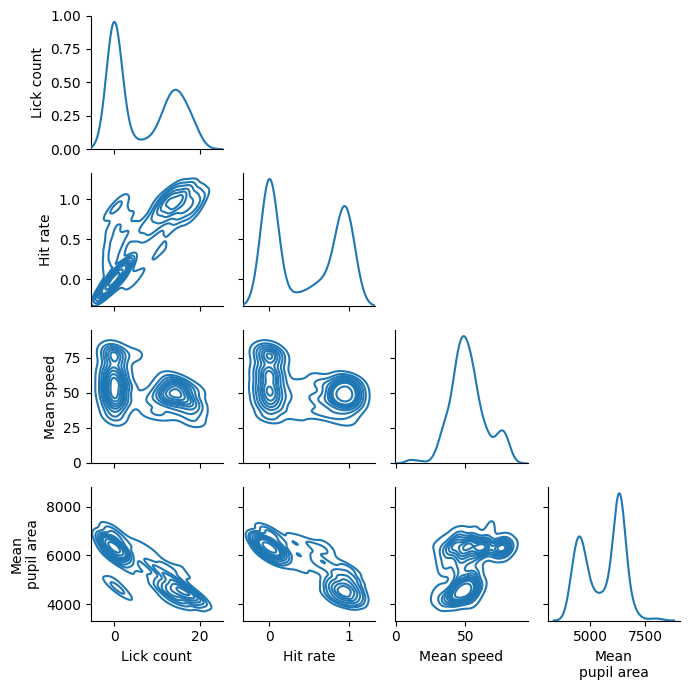

In [110]:
def hide_current_axis(*args, **kwds):
    # function to hide upper triangle of the pairwise plots
    plt.gca().set_visible(False)

# Set layout for pairwise plot - 4 X 4 plot grid
g = sns.PairGrid(behavior_data, hue = 'Trials', vars=['Lick count', 'Hit rate', 'Mean speed', 'Mean\npupil area'], diag_sharey=False)

# Plot 2D density plot in the lower triangle 
bw = 'scott'
bw = 0.25
g.map_lower(sns.kdeplot, hue=None, bw_method = bw)

# Hide the upper triangle 
g.map_upper(hide_current_axis)

# Plot 1D density plot
g.map_diag(sns.kdeplot, hue=None, legend=False, bw_method = bw)

# Formatting 
g.fig.set_size_inches(7,7)
g.fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> This visualization is much in line with our previous assessment of behavioral states. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1: </b> In the last workshop, we saw that engaged mice tend to stop to lick. Try plotting the variance of the running speed in place of the running speed itself. Discuss with your neighbors which choice gives you more insight into the trialwise mouse behavior.
</div>

In [6]:
# Code block for task 2.1 with starter code.

# std_speed = [np.nanstd(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# putting it together in a dataframe
# other_behavior = pd.DataFrame({'Trials': go_trials, 
#             'Lick_rate': lick_rate, 
#             'Hit_rate':hit_rate,
#             'Running_speed_std': std_speed,
#             'Running_speed': mean_speed,
#             'Pupil_area': mean_pupil_area})

# g = sns.PairGrid(other_behavior, hue = 'Trials', vars=['Lick_rate', 'Hit_rate','Running_speed_std','Running_speed', 'Pupil_area'], diag_sharey=False)
# g.map_lower(sns.kdeplot, hue=None, lw = 0.5)
# g.map_upper(hide_current_axis)
# g.map_diag(sns.kdeplot, hue=None, lw=1, legend=False)
# g.fig.set_size_inches(6,6)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.2: </b> In the pairwise density plots, try playing around with the option 'bw_method' by setting it to scalar values between [0.2, 1]. How does this effect the density plots? Do you still think there are only 2 states?  
</div>

In [7]:
# Code block for task 2.2

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> This visualization broadly showed two states that mapped well to our previous state definitions. But playing around with the density plots may have raised some doubts. 
    
<p> Does every peak deserve a behavior state? How can we define state boundaries? Are there other behavior states that we should identify?
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Can we use K-means? </h4>

<p> The density plots may remind you of clusters you saw on Day 3, where we used the unsupervised clustering method, K-means, to identify cell types. Should we try the K-means here?
    
<p> K-means is a simple and powerful tool for clustering. Another method similar to Kmeans, but that offers more flexibility in cluster assignment is Gaussian Mixture models (GMM). While K-Means assigns each data point to a single cluster with a deterministic assignment, GMMs allow data points to belong to multiple clusters with varying degrees of membership probabilities, making them more flexible than K-Means. A limitation of Kmeans lies in its assumption of spherical clusters. GMMs clusters can be of different shapes and orientations.These are just some of the differences.
    
<p> Similar to K-Means, GMMs aim to group data points based on similarity, but they introduce a probabilistic framework. Let us see how we draw a link from k-means clustering to GMMs. By making this connection, we will introduce a new tool to your toolbox: the notion of a mixture model which maximizes the likelihood of the observed data.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> K-means and Gaussian mixture models</h3>
    
<p> First, lets sort out our notations: 
<br> <b> Constants and data </b> 
<br> $N$ - number of data points. 
<br> $K$ - number of clusters/components
<br> $x_{n} \in R^{D}$ - $n^{th}$ input data point
<br> $z_{n} \in \{1, ..., K\}$ - cluster/component assignment for $n^{th}$ data point
<br> <b> Model parameters</b>   
<br> $\theta_{k}$ - parameters of the $k^{th}$ cluster/component
<br> $\pi$ - component probabilities/cluster proportions
<br> <b> Model hyperparameters</b>   
<br> $\phi$ - hyperparameters of the prior on $\theta$ 
    

<p> The objective of GMM is that, for each $n = 1, ..., N, $ we need to find $z_{n}^{*}$ and $\theta_{k}^{*}$ that maximizes the probability
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi)
\end{align}
<p> Lets assume a uniform distribution on the prior and $\pi = \frac{1}{K}\textbf{1}_{K}$,    
<br> To quantify $z_{n}^{*}$, we fix all variables but $z_{n}$, then, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) \propto p(x_{n}|z_{n}, \{\theta\}_{k = 1}^{K}) = \mathcal{N}(x_{n}|\theta_{z_{n}}, \textbf{I})
\end{align}
<br> The <b>cluster/component assignment</b> that maximizes the likelihood is the one with the closest mean to $x_{n}$, that is, 
\begin{align}
z_{n}^{*} = \underset{k \in \{1,..., K\}}{arg min} || x_{n} - \theta_{k}||_{2}
\end{align}
<br> 2. Similarly, to quantify $\theta_{k}^{*}$, we fix all variables but $\theta_{k}$. In this case, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) & \propto \prod_{n = 1}^{N} p(x_{n}|\theta_{k})^{\textbf{I}[z_{n} = k]} \\
    & \propto exp \biggl\{\sum_{n=1}^{N} \textbf{I}[z_{n} = k](x_{n}^{T}\theta_{k} - \frac{1}{2}\theta_{k}^{T}\theta_{k}) \biggr\}
\end{align}
<br> Taking the derivative of the log and setting to zero yields,
\begin{align}
\theta_{k}^{*} = \frac{1}{N_{n}}\sum_{n = 1}^{K} \textbf{I}[z_{n} = k]x_{n}, 
\end{align}   
<br> where, $N_{k} = \sum_{n=1}^{N}\textbf{I}[z_{n} = k]$
<p> If you recall from Day 3, this is the K-means algorithm!
    
<p> As previously discussed, GMMs offer flexible clustering by accommodating data points in multiple clusters with varying probabilities. The challenge, then, is to determine these probabilities. Here, we introduce expectation maximization,  which is an iterative optimization technique utilized to estimate the parameters of the GMM model.
</div>

<h4 align="left">Gaussian mixture models</h4> 

<center><img src="../code/GMM.png" width="400" height="500" > </center>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Expectation - Maximization </h4>
<p> K-Means made hard assignments of data points to clusters in each iteration. What if we used soft assignments instead? So, instead of assigning $z_{n}^{*}$ to the closest cluster, we compute <i>responsibilities</i> for each cluster. In that case, 
<br> 1. For each data point $n$ and component $k$, we set the <i>responsibility</i> to, 
\begin{align}
    \omega_{nk} = \frac{\pi_{k}\mathcal{N}(x_{n}|\theta_{k}, \textbf{I})}{\sum_{j = 1}^{K}\pi_{j}\mathcal{N}(x_{n}|\theta_{j}, \textbf{I})}
\end{align}
<br> 2. For each component $k$, we set the new mean to, 
\begin{align}
   \theta_{k}^{*} = \frac{1}{N_{k}}\sum_{n = 1}^{N}\omega_{nk}x_{n} 
\end{align}
<br> where $N_{k} = \sum_{n=1}^{N}\omega_{nk}$. 
    
<p> This is Expectation Maximization (EM). EM maximizes the marginal probability, instead of the joint probability and typically obtains faster convergence rates.  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> But its not simply enough to fit a Gaussian distribution to our behavioral data. While GMMs are a powerful tool for clustering and learning probabilistic associations in our data,they assume that each data point is independent of others. When determining behavioral states, we are dealing with data that changes over time, where the current state may depend on the current observation and also on the previous state. A choice which fulfills the goal are state-space models. 
    
<p> State space models are a framework used to understand and predict complex systems that change over time. They are particularly useful when dealing with dynamic processes that might not be directly observable but can still influence the observed data. Sound familiar? 
    
<p> The state-space model that we will be exploring in this workshop is the Gaussian hidden Markov model (HMM). 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Gaussian hidden Markov model </h4>
<p> A Gaussian HMM introduces the notion of dynamics to state determination. The behavior of an HMM is fully determined by three probabilties: 
  
<p> <i> Transition probability, $p(s_{t+1} \mid s_{t})$ </i>- the probability of $s_{t+1}$ given its previous state $s_t$.  We can describe the transition probability by a M $\times$ M matrix which is called transition matrix. The $(i,j)^{th}$ element of the matrix denotes the probability of the state transiting from the $i^{th}$ state to the $j^{th}$ state.
    
<p> <i> Emission probability, $p(y_{t}\mid s_{t})$ </i> - the probability of the observation $y_{t}$ given its hidden state $s_{t}$. Specifically, for a Gaussian HMM, emission probabilties take the following form, 
\begin{align}
p(y_t \mid s_t, \theta) &= \mathcal{N}(y_t \mid \mu_{s_t}, \Sigma_{s_t})
\end{align}
where the emission parameters $\theta = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.

<p> <i> Initial state distribution $\pi(s_{0})$ </i> 
</div>

<h4 align="left">Hidden Markov models</h4> 

<center><img src="../code/gHMM.png" width="300" height="400"> </center>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>So, lets try out HMM models! First, let's take a moment to import our minmal set of packages. This might take a few minutes. 
    
<ul> Dynamax is a package created in collaboration between the Linderman lab and Google building around a JAX engine. JAX is a functional language which handles the backend for fast computation while presenting similarly to numpy. This means that you'll want to carry state along between calls. 
  
<p> Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). It also includes prior distributions on the parameters.

</div>

In [8]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax
    
import warnings
warnings.filterwarnings("ignore")

In [9]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.3: </b> As we discuss this these helper functions below, add to the docstring a comment about when you should use each of these helper functions. 
</div>

In [27]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Before we apply HMMs to real data, let's start with using Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [13]:
# Set up training parameters
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
observations_dim = 2
hmm = GaussianHMM(true_num_states, observations_dim)

# Set the initial state distribution
initial_probs = jnp.ones(true_num_states) / true_num_states

# Set the transition matrix
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states

# Set the emission probabilities - mean and covariances
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, observations_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(observations_dim), (true_num_states, 1, 1))
  
# Construct the HMM - this will be our ground truth 
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Set up training, validation, and test datasets
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_observations = f(jr.split(train_key, num_train_batches))
test_true_states,  test_observations = f(jr.split(test_key, num_test_batches))


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets visualize how the HMM was modeled. For this, we can plot the 2D-data, and superimpose each states' Gaussian fit. 
</div>

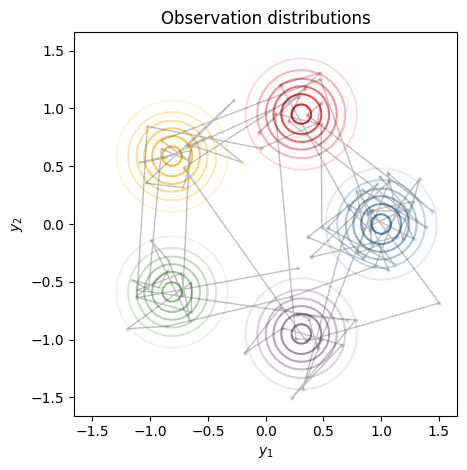

In [14]:
# Plot emissions and true_states 
plot_gaussian_hmm(hmm, true_params, train_observations[0], train_true_states[0], 
                  title="Observation distributions")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.4: </b> How does the HMM data change as you alter the transition matrix? How does it change when you alter the emission variance? You can also try to play with the initial state distribution. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> By plotting these states as a function of time, the interplay between descrete latent states, transition matrix mediated dynamics (Markov process) and the observations (or emissions) becomes more clear.
</div>

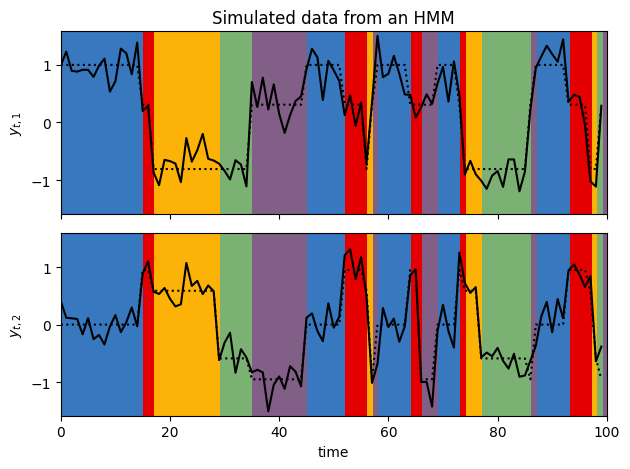

In [15]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.
    
<p> This function fits the data into _folds_ where each fold consists of all but one of the training sequences. It fits the model to each fold in  parallel, and then computs the log likelihood of the held-out sequence for each fold. The average held-out log likelihood is what we will use for determining the number of discrete states.
</div>



In [16]:
def cross_validate_model(model, key, num_iters=100):
    
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method='kmeans', emissions=train_observations)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_observations[:i], train_observations[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        # Funtion to fit the HMM
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_observations)
    return val_lls.mean(), val_lls

In [18]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, observations_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []


for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.5:</b>  Plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

In [21]:
# Blank coding cell to work out Task 2.1


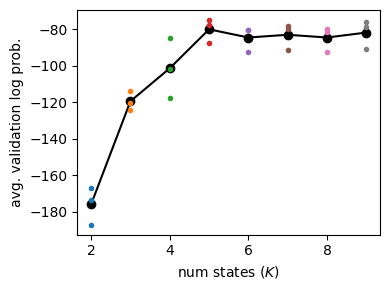

In [22]:
plt.figure(figsize = (4, 3))
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> How should we choose the right number of states? 
    
<p> There's no single "right" answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


In [23]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now let's fit our model with the best number of states. Using the number of states with the highest loglikelihood average, we can fit our Gaussian HMM.
</div>

In [25]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, observations_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_observations)
params, lps = test_hmm.fit_em(params, props, train_observations, num_iters=100)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.5:</b>  Plot up the log-likelihood and compare it to the actual lp.
</div>

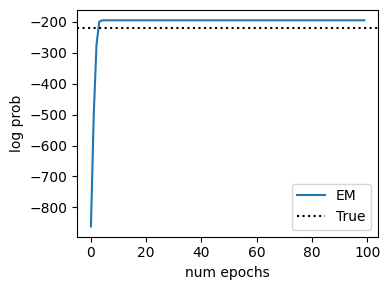

In [26]:
# Helper code for task 2.5

# Evaluate the log probability of the training data under the true parameters
true_lp = vmap(partial(hmm.marginal_log_prob, params))(train_observations).sum()
true_lp += hmm.log_prior(params)

# Plot log probs vs num_iterations
offset = 0
plt.figure(figsize = (4, 3))
plt.plot(jnp.arange(len(lps)-offset), lps[offset:], label='EM')
plt.axhline(true_lp, color='k', linestyle=':', label="True")
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.6:</b>  Compare the inferred states to the actual states by using the plot_gaussian_hmm_data() method for both the inferred and actual states. Discuss with your neighbors what you observe and if you can spot any errors.
    
<p> If you finish early, please consider which of the features of this data would make it more difficult to reconstruct and what you might expect the failure to look like. What would happen if you choose too many states? Too few?
</div>

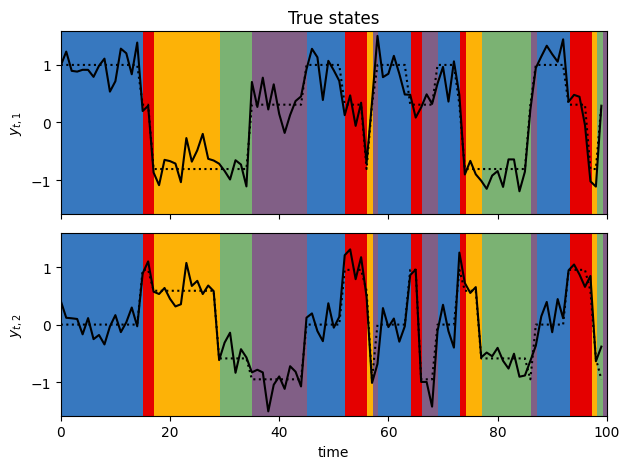

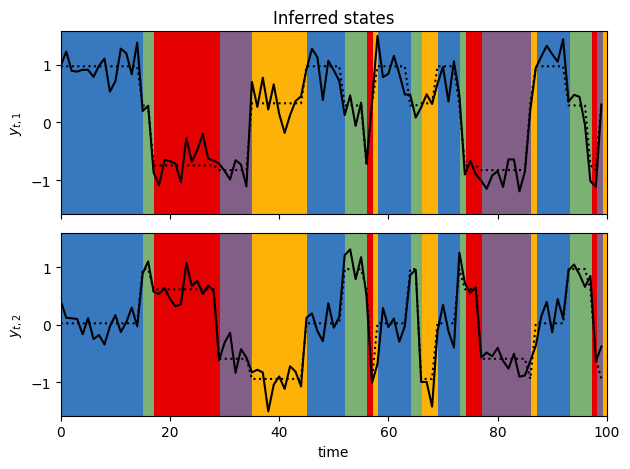

In [30]:
# helper code for task 2.6

plot_gaussian_hmm_data(hmm, true_params, train_observations[0], train_true_states[0], title = 'True states')

# Get inferred states
most_likely_states = hmm.most_likely_states(params, train_observations[0])

# Ask Scott for hmm.permute? 
plot_gaussian_hmm_data(hmm, params, train_observations[0], most_likely_states, title = "Inferred states")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> State determination in Visual Behavior mice </h3>
<p> We now kind of get a hang of HMM. So, let's take what we've done above and apply it to the behavior variables from the previous workshop to automatically detect states in our mice! Now, we have the capability to incorporate a multi-dimensional dataset to inform our state boundaries. 
<p> To accomplish this goal, we will fit our data to a Gaussian HMM. 
    
<p> To complement our states from the previous workshop, lets extract the behavior states using only behavior data, that is, pupil size, running speed and lick counts.
</div>

In [111]:
# Extract data for running state analysis
data = behavior_data[['Lick count', 'Mean speed', 'Mean\npupil area']].values
data[np.isnan(data)] = 0

# For this model, it's important that the data is converted into a *JAX* array
observations = jnp.array(data)

# Split the data into equal length batches for cross-validation
n_batches = 3
n_steps = data.shape[0] - (data.shape[0] % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now, lets train and test our models! 
</div>

In [78]:
# Define empty lists that we'll populate below
avg_test_log_probs = []
std_test_log_probs = []
lp_all = []
numstates_all = []
key = jr.PRNGKey(0)

# Run a loop to fit the data to a range of states
for num_states in range(2, 8):
    print("num states: ", num_states)

    test_log_probs = []
    
    for batch in trange(n_batches):
        # Extract all but this batch for training
        train_data = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]]).reshape((n_batches - 1)*batch_size, -1)
        
        # Standardize the dataset 
        # this is important so that appropriate weights are assigned to each feature 
        scaler = StandardScaler()
        train_observations = scaler.fit_transform(train_data)
        
        # Make an HMM
        hmm = GaussianHMM(num_states, batched_observations.shape[2])
        params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

        # Fit the model
        params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
        
        # Evaluate the log probability on held out data
        test_lp = hmm.marginal_log_prob(params, scaler.transform(jnp.array(batched_observations[batch])))
        test_log_probs.append(test_lp)
        lp_all.append(test_lp)
        numstates_all.append(num_states)
       
    # Store the average test log prob
    avg_test_log_probs.append(np.mean(test_log_probs))
    std_test_log_probs.append(np.std(test_log_probs))    

num states:  2


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:04,  2.38s/it]

 67%|██████▋   | 2/3 [00:04<00:02,  2.38s/it]

100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


num states:  3


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.52s/it]

 67%|██████▋   | 2/3 [00:05<00:02,  2.92s/it]

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


num states:  4


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.64s/it]

 67%|██████▋   | 2/3 [00:05<00:02,  2.66s/it]

100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


num states:  5


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]

 67%|██████▋   | 2/3 [00:05<00:02,  2.63s/it]

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


num states:  6


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.62s/it]

 67%|██████▋   | 2/3 [00:05<00:02,  2.62s/it]

100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


num states:  7


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.64s/it]

 67%|██████▋   | 2/3 [00:05<00:02,  2.63s/it]

100%|██████████| 3/3 [00:07<00:00,  2.62s/it]


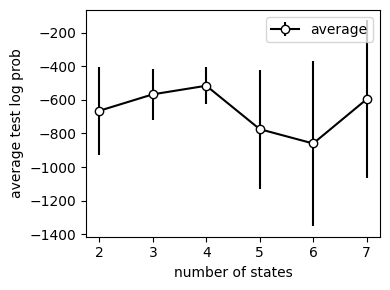

In [79]:
plt.figure(figsize = (4, 3))
plt.errorbar(np.arange(2, 8), avg_test_log_probs, yerr = std_test_log_probs, mfc = 'w', color = 'k', marker = 'o')
# plt.scatter(numstates_all, lp_all, c='k')
plt.legend(['average'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.7:</b>  Choose the best number of states and discuss with your neighbors why the shape of the cross-validation could be the way it is? Are there any other metrics you could use to decide on the number of states? 
</div>

In [80]:
# Blank coding cell to work out Task 2.7


In [81]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_test_log_probs))]
print("best number of states:", best_num_states)

best number of states: 4


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets finally fit our model to the behavior variables, and see how that compares with our previous definition of behavioral states using hit rate.  
</div>

In [112]:
key = jr.PRNGKey(0)

number_of_states = best_num_states

input_data = behavior_data[['Lick count', 'Mean speed', 'Mean\npupil area']].values

final_hmm = GaussianHMM(number_of_states, input_data.shape[1], transition_matrix_stickiness=10.)

params, props = final_hmm.initialize(key=key, method="kmeans", emissions=input_data)

params, lps = final_hmm.fit_em(params, props, input_data, num_iters=500)

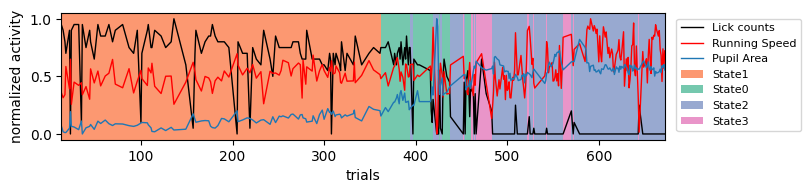

In [106]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 

# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, input_data)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(figsize=(8.3, 2))
cmap =sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))

# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    for state_no in range(best_num_states):
        if states[trial+1] == state_no: 
            ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], 
                       facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

# Overlay behavioral variables 
plt.plot(go_trials, minmax(lick_count), '-k', label="Lick counts", lw = 1 )
plt.plot(go_trials, minmax(mean_speed), color = 'r', label="Running Speed", lw = 1)
plt.plot(go_trials, minmax(mean_pupil_area), color = 'tab:blue', label="Pupil Area", lw = 1)


# Formatting 
plt.xlim(go_trials[0], go_trials[-1])
plt.ylabel("normalized activity")
plt.xlabel("trials")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1), fontsize = 8)
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Looks like these behavioral states track changes that appear simultaneously in all behavior variables.Let's see how our new states compare with the states that we defined using hit rate in workshop 1.  
</div>

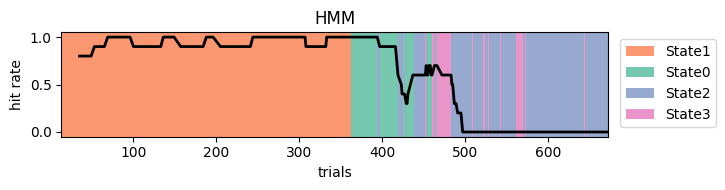

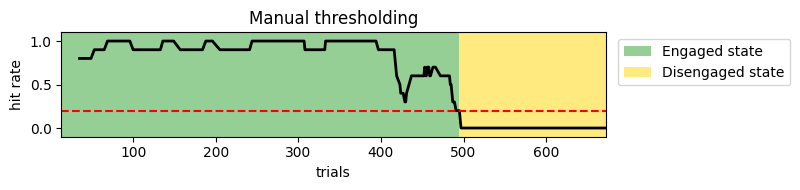

In [108]:
fig, ax = plt.subplots(figsize=(7.45, 2))
cmap = sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# 1. New states: 

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))

# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    for state_no in range(best_num_states):
        if states[trial+1] == state_no: 
            ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

# Overlay the hit rate
plt.plot(go_trials, hit_rate, color = 'k', lw = 2)
plt.xlim(go_trials[0], go_trials[-1])

# Formatting 
plt.xlabel("trials")
plt.ylabel('hit rate')
plt.title('HMM')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

# 2. States From WS - 1 
engagement_threshold = 0.2

# Overlay the hit rate plot
fig,ax = plt.subplots(figsize = (8.2, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials, 0.2*np.ones(len(go_trials)), color = 'r', ls = '--')

# Define state boundaries 
states = hit_rate < engagement_threshold
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))


# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    if not states[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5, label = 'Engaged state')
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5,label = 'Disengaged state')

# Formatting 
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
plt.title('Manual thresholding')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In the HMM states, it's evident that State-2 corresponds to the manually defined disengaged state, while State-1 corresponds to the engaged state. State-0 and State-3 are more prominent during the transition. Clearly, HMM states are more refined in their definition of behavioral states. For instance, State-1 (engaged state) only encompasses trials where the mouse performs consistently well. Whereas, in our manual definition of behavioral states, we had to choose between defining an appropriate disengaged state or an engaged state, resulting in us ignoring the intricacies of the transition states.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In this workshop, we undertook a more sophisticated approach to understand behavioral states. In doing so, we learnt various algorithmic tools, practices and softwares for probabilistic modeling. Lastly, we addressed the gaps in our understanding and analyses we had identifed in the previous workshop. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1:</b>  Recalling our previous manual determination on this session. Do you see any signals of the disengaged state? How can we amplify them by defining the precision and recall?
    
   Rather than looking at all four of these quantities, we often summarize them in terms of the _precision_ (here, the fraction of licks that were hits) and _recall_ (here, the fraction of changes that the mouse hit)
</div>

How does neural activity change in HMM states? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 1.2:</b> Fit a GLM-HMM (in the form of a simplified Logistic Regression HMM) to the behavior data to identify states? Be sure to apply cross-validation and identify a reasonable number of states. Then study the latent states, the posterior distributions, and the state progression over trials. Does it agree with what you found in workshop1 and workshop2? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 1.3:</b> How do the behavioral states differ across mice or sessions? Are some mice better performers than others?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> You can think of the inferred behavioral states as features that have been derived from the behavioral data. These features are prime candidates to correlate with neural measurements. Do you think the neural responses to flashes/changes/omissions will differ from behavioral state to the next? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> Likewise, we can correlate the inferred behavioral states with other aspects of the animal's behavior. Have we simply constructed a fancy way of extracting running speed and/or pupil size?
</div>